In [ ]:
#!pip install -q transformers datasets evaluate

In [ ]:
#!pip install ipywidgets
#!pip install huggingface_hub
#!pip install matplotlib
#!pip install opencv-python
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install lightning

### Login into huggingface

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# GPU Config

### Check for free gpu to use for parallel computing

In [1]:
import subprocess

# Run nvidia-smi command
result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

Mon Mar 18 13:54:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000                On | 00000000:01:00.0 Off |                    0 |
| 76%   86C    P2              228W / 230W|   4395MiB / 23028MiB |     93%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### The Dataset is created by cropping the original images and labels into a size of (640x640). These crop images are then split into train test and val respectively based on ratio of (0.6, 0.2 and 0.2) respectively.

# Data Augmentation

In [ ]:
#pip install -U albumentations

In [ ]:
import albumentations as A

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx] + '.jpg')
        mask_path = os.path.join(self.masks_dir, self.filenames[idx] + '.png') 
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") 
        batch={"pixel_values": image, 
               "labels": mask
              }
        if self.transform:
            batch = self.transform(batch)
            for k,v in batch.items():
                batch[k].squeeze_() # remove batch dimension
                v[v==255]=1
                
        return batch

In [ ]:
images_dir = "metalchip_dataset/images/train"
masks_dir = "metalchip_dataset/labels/train"
train_ds = ImageSegmentationDataset(images_dir, masks_dir)

In [ ]:
image=train_ds[5]['pixel_values']
label=train_ds[5]['labels']

In [ ]:
import matplotlib.pyplot as plt

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Label')
plt.imshow(label)

plt.show()

In [ ]:
import numpy as np

np_image = np.array(image)
np_label = np.array(label)

In [ ]:
# Define the transformation
HFlip = A.Compose([
    A.HorizontalFlip(p=1),  
])
# Define the transformation
VFlip = A.Compose([
    A.VerticalFlip(p=1),  
])
CJ = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.7, hue=0.2, p=1),
])

## Horizontal Flip

In [ ]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = HFlip(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

## Vertical Flip

In [ ]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = VFlip(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

## ColorJitter 

In [ ]:
import matplotlib.pyplot as plt

# Apply the transformation
transformed = CJ(image=np_image)
transformed_image = transformed["image"]

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(np_image)

plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_image)

plt.show()

# Load Dataset

### Create dataset dict with the images and labels

### The Dataset dict is created by passing in the image directory as well as the labels directory. Images are in jpg format while the labels are in png format. The dictionary entries can be accessed by indexing e.g. dataset[idx]. The images and labels are converted to arrays. The label's pixel_values are also converted from 255 to 1 in order to match the output from argmax from the model's prediction later. For each dictionary entries, there are two elements.
### To access image, dataset[idx][0]. 
### To access label, dataset[idx][1].

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader 
import torch

class ImageSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if not f.startswith('.')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx] + '.jpg')
        mask_path = os.path.join(self.masks_dir, self.filenames[idx] + '.png') 
        image = Image.open(img_path).convert("RGB")
        np_image=np.array(image)
        # convert to C, H, W
        np_image = np_image.transpose(2,0,1)
        mask = Image.open(mask_path) 
        np_mask=np.array(mask)
        np_mask[np_mask==255]=1
                
        return np_image, np_mask

# Defining Data Module from pytorch lightning

### Defining Data Module as Mask2Former takes in class_labels and mask_labels as a list of tensors and pytorch lightning is unable to load it directly as it expects tensor instead of a list from dataloader.
### collate_fn is used to group images and labels together for each batch instead of each batch containing an image and label.
### While loading the dataloaders, Mask2FormerImageProcessor  is used to process the images and labels for each batch. Mask2FormerImageProcessor normalizes the input using ImageNet mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225) and then convert it to tensor. 
### The output size from the Mask2FormerImageProcessor is a batch of images with size (2, 3, 640, 640), a batch of pixel_masks of size (2, 640, 640), which is used to signify the images is not masked, a mask_labels of size (2,640,640) and a class_labels of size (2). The label is converted to lists of binary masks and their respective labels which are mask_labels and class_labels respectively.

In [2]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images=inputs[0]
    segmentation_maps=inputs[1]
    batch = processor(
        images,
        segmentation_maps=segmentation_maps,
        size=(640,640),
        return_tensors="pt",
    )
    batch["original_images"] = images
    batch["original_segmentation_maps"] = segmentation_maps

    return batch

In [3]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir, batch_size, num_workers, processor=None):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.processor = processor
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'train'),
                                                          masks_dir=os.path.join(self.dataset_dir, 'labels', 'train'),
                                                          transform=None) # Add your transforms here
            self.val_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'val'),
                                                        masks_dir=os.path.join(self.dataset_dir, 'labels', 'val'),
                                                        transform=None) # Add your transforms here
        if stage == 'test' or stage is None:
            self.test_dataset = ImageSegmentationDataset(images_dir=os.path.join(self.dataset_dir, 'images', 'test'),
                                                         masks_dir=os.path.join(self.dataset_dir, 'labels', 'test'),
                                                         transform=None) # Add your transforms here
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=collate_fn)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, collate_fn=collate_fn)

### Initialise Mask2Former processor

In [4]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

In [5]:
batch_size=1
num_workers=4

data_module = SegmentationDataModule(dataset_dir='data_augmentation_dataset', batch_size=batch_size, num_workers=num_workers, processor=processor)

### Check dataloader has the proper config for Mask2Former model

In [6]:
data_module.setup(stage='fit')
train_dataloader = data_module.train_dataloader()

In [7]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 640, 640])
pixel_mask torch.Size([1, 640, 640])
mask_labels torch.Size([2, 640, 640])
class_labels torch.Size([2])
original_images (3, 640, 640)
original_segmentation_maps (640, 640)


### Creating id for the class

In [8]:
newid2label={
    0: 'Background',
    1: 'Metal Lines'
}
newid2label

{0: 'Background', 1: 'Metal Lines'}

In [9]:
newlabel2id = {v: k for k, v in newid2label.items()}
newlabel2id

{'Background': 0, 'Metal Lines': 1}

In [10]:
from transformers import Mask2FormerForUniversalSegmentation
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics import Metric
from datasets import load_metric
from torch import nn
import numpy as np
import random
import torch
torch.set_float32_matmul_precision("medium")
import evaluate

## Defining Pytorch Lightning Module

In [11]:
class Mask2FormerFinetuner(pl.LightningModule):

    def __init__(self, id2label):
        super(Mask2FormerFinetuner, self).__init__()
        self.id2label = id2label
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        self.model = Mask2FormerForUniversalSegmentation.from_pretrained(
            "facebook/mask2former-swin-small-ade-semantic",
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        evaluate.load
        self.train_mean_iou = evaluate.load("mean_iou")
        self.val_mean_iou = evaluate.load("mean_iou")
        self.test_mean_iou = evaluate.load("mean_iou")
        
    def forward(self, pixel_values, mask_labels=None, class_labels=None):
        # Your model's forward method
        return self.model(pixel_values=pixel_values, mask_labels=mask_labels, class_labels=class_labels)
        
    def transfer_batch_to_device(self, batch, device, dataloader_idx=0):
        batch['pixel_values'] = batch['pixel_values'].to(device)
        batch['mask_labels'] = [label.to(device) for label in batch['mask_labels']]
        batch['class_labels'] = [label.to(device) for label in batch['class_labels']]
        return batch

    def training_step(self, batch, batch_idx):
        outputs = self(
            pixel_values=batch["pixel_values"],
            mask_labels=batch["mask_labels"],
            class_labels=batch["class_labels"],
        )
        loss = outputs.loss
        self.log("loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(
            pixel_values=batch["pixel_values"],
            mask_labels=[labels for labels in batch["mask_labels"]],
            class_labels=[labels for labels in batch["class_labels"]],
        )
        loss = outputs.loss
        self.log("loss", loss)
        return loss
    def test_step(self, batch, batch_idx):
        outputs = self(
            pixel_values=batch["pixel_values"],
            mask_labels=[labels for labels in batch["mask_labels"]],
            class_labels=[labels for labels in batch["class_labels"]],
        )
        loss = outputs.loss
        original_images = batch["original_images"]
        ground_truth = batch["original_segmentation_maps"]
        target_sizes = [(image.shape[1], image.shape[2]) for image in original_images]
        # predict segmentation maps
        predicted_segmentation_maps = processor.post_process_semantic_segmentation(outputs,target_sizes=target_sizes)
        # Optionally log loss here
        metrics = self.train_mean_iou._compute(
            predictions=predicted_segmentation_maps[0].cpu().numpy(),
            references=ground_truth[0],
            num_labels=self.num_classes,
            ignore_index=254,
            reduce_labels=False,
        )
        # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()
    
        # Re-define metrics dict to include per-category metrics directly
        metrics = {
            'loss': loss, 
            "mean_iou": metrics["mean_iou"], 
            "mean_accuracy": metrics["mean_accuracy"],
            **{f"accuracy_{self.id2label[i]}": v for i, v in enumerate(per_category_accuracy)},
            **{f"iou_{self.id2label[i]}": v for i, v in enumerate(per_category_iou)}
        }
        for k,v in metrics.items():
            self.log(k,v,sync_dist=True,batch_size=batch_size)
        return(metrics)
        
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=0.0001)

# Initialising Model

### Load previously trained model

In [12]:
path="mask2former_checkpoint_14Mar.ckpt"
model = Mask2FormerFinetuner.load_from_checkpoint(path,id2label=newid2label)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training the model

### Training, Val and test is done using python instead

# Test model performance

In [13]:
model.eval()

Mask2FormerFinetuner(
  (model): Mask2FormerForUniversalSegmentation(
    (model): Mask2FormerModel(
      (pixel_level_module): Mask2FormerPixelLevelModule(
        (encoder): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x SwinLayer(
                    (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=96, out_features=96, bias=True)
                        (key): Linear

### Function to get the respective batch by index

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

Mask2FormerFinetuner(
  (model): Mask2FormerForUniversalSegmentation(
    (model): Mask2FormerModel(
      (pixel_level_module): Mask2FormerPixelLevelModule(
        (encoder): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x SwinLayer(
                    (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=96, out_features=96, bias=True)
                        (key): Linear

In [16]:
data_module.setup(stage='test')
test_dataloader = data_module.test_dataloader()

In [17]:
len(test_dataloader)

576

In [18]:
def getBatch(index):
    data_module.setup(stage='test')
    test_dataloader = data_module.test_dataloader()
    test_iterator = iter(test_dataloader)
    for i in range(index):
        batch = next(test_iterator)
    return batch

In [19]:
batch=getBatch(177)

### Function to view mask

### Function to do predictions for a batch

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def viewMask(batch):
    # Plot expects (height, width, channels), hence transpose.
    image=batch["original_images"][0]
    label=batch["original_segmentation_maps"][0]
    image_transpose = np.transpose(image, (1, 2, 0))
    
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Image", {'fontsize': 40})
    axs[0].imshow(image_transpose)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

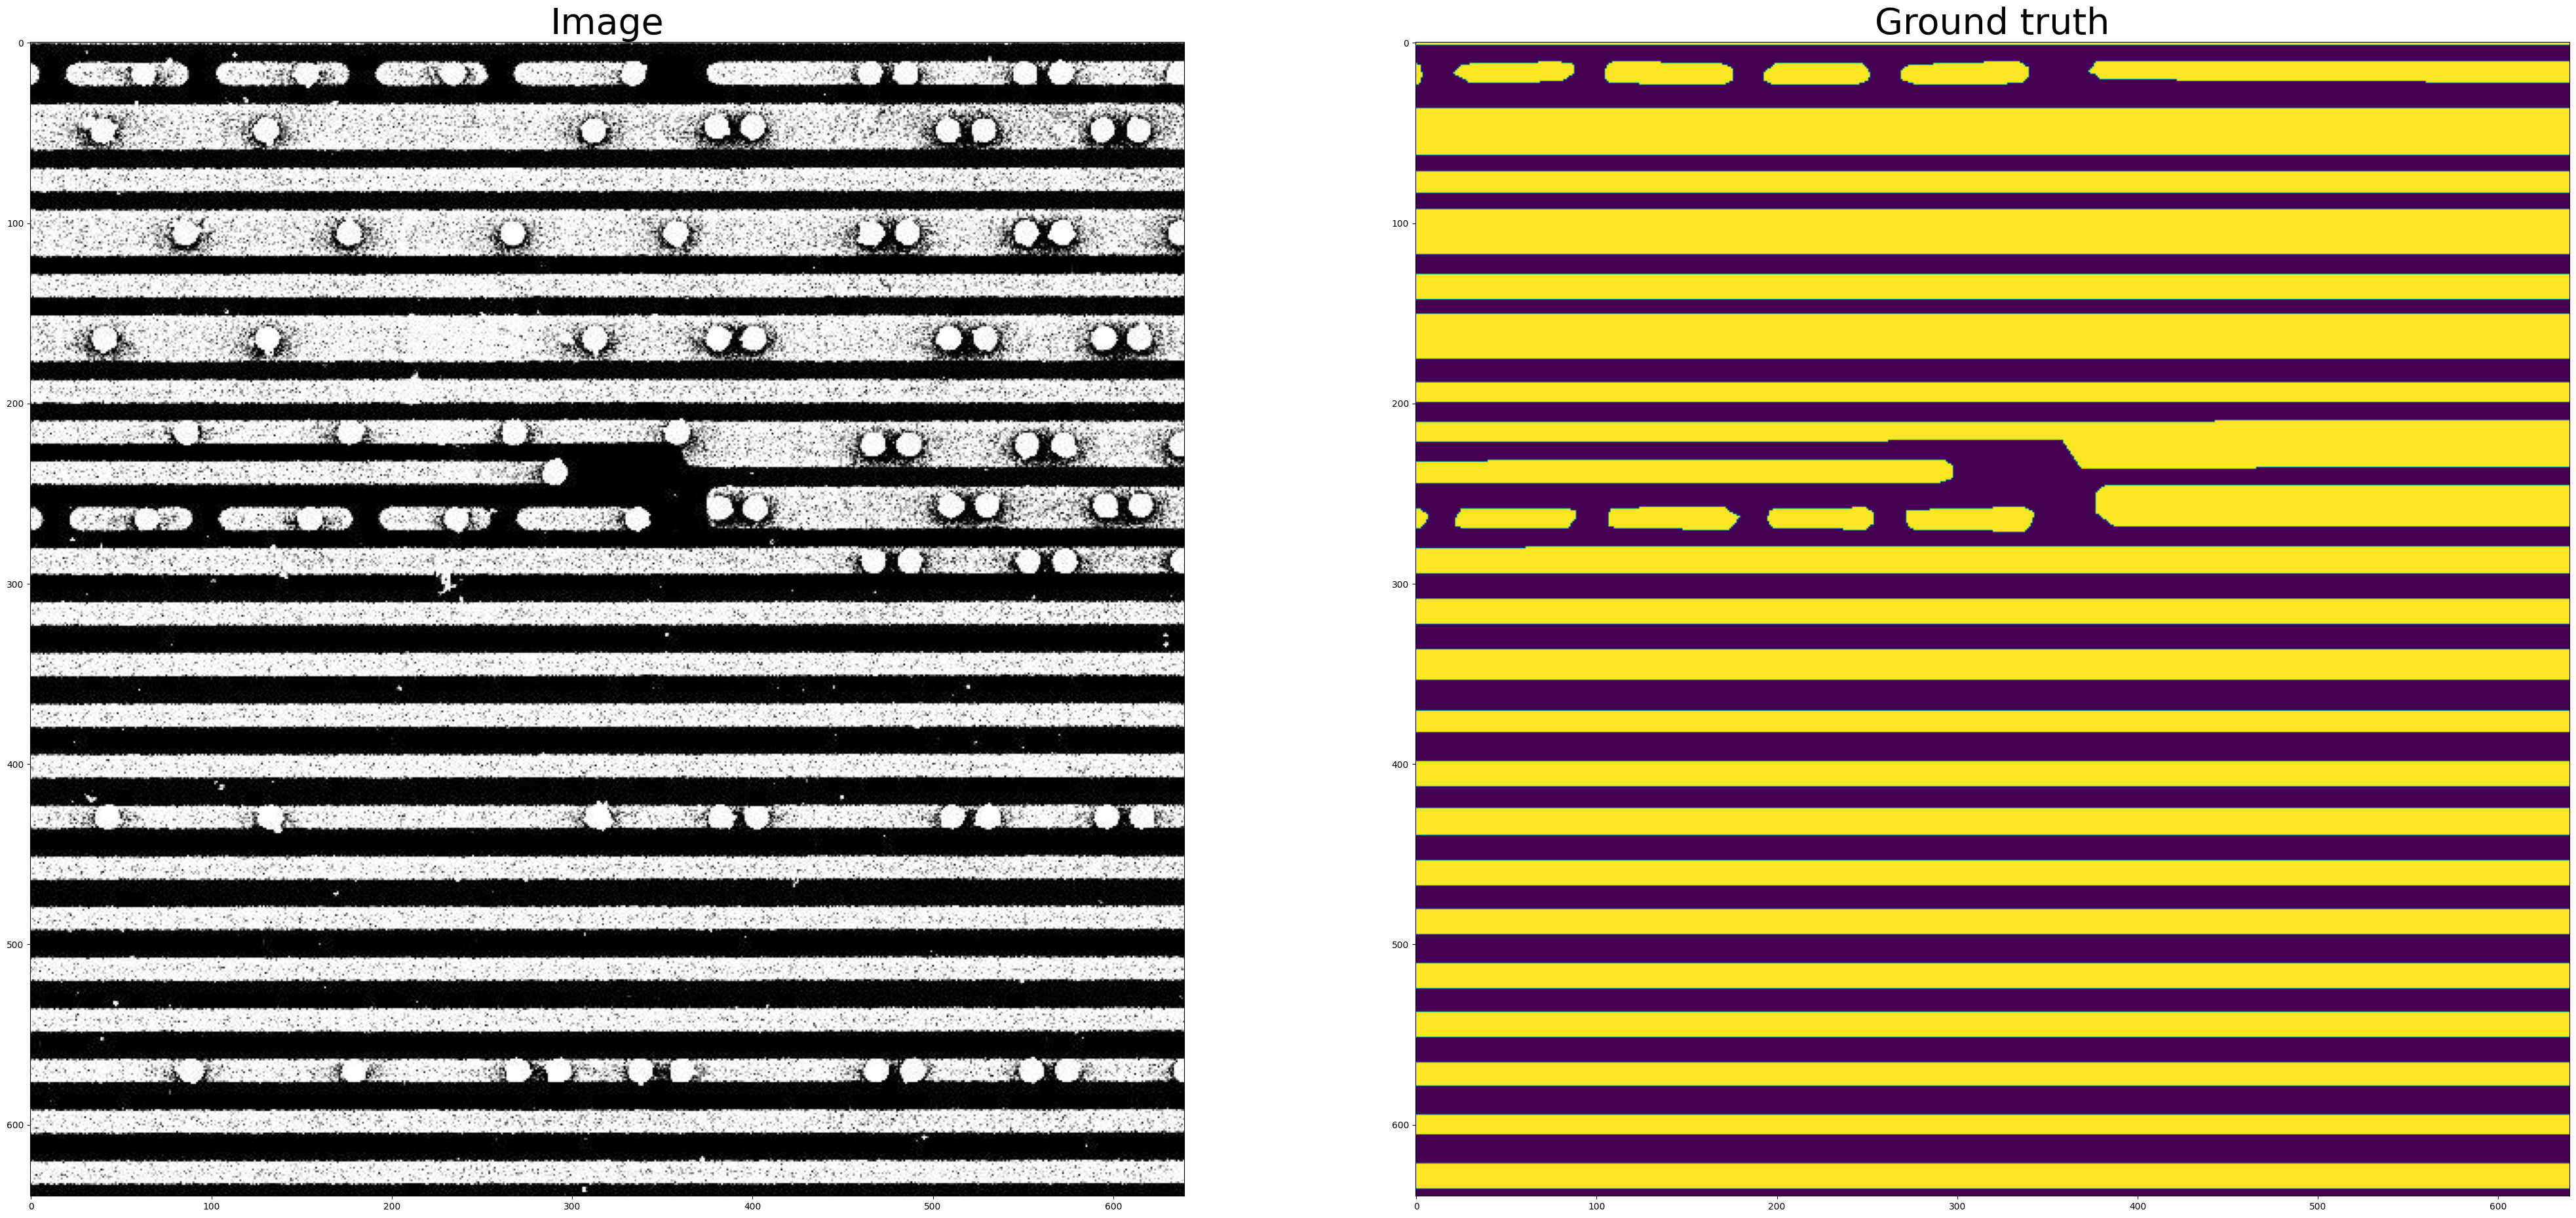

In [21]:
viewMask(batch)

In [22]:
#Batch size=1
def batch_prediction(batch):
    original_images = batch["original_images"]
    target_sizes = [(image.shape[1], image.shape[2]) for image in original_images]
    outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
    result = processor.post_process_semantic_segmentation(outputs,target_sizes=target_sizes)[0].cpu().numpy()
    original_segmentation_maps = batch["original_segmentation_maps"][0]
    return result, original_segmentation_maps

In [23]:
pred_semantic_map,label=batch_prediction(batch)

In [24]:
def viewPrediction(prediction,label):
    # Need to convert image and labels to numpy to plot. 
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Prediction", {'fontsize': 40})
    axs[0].imshow(prediction)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

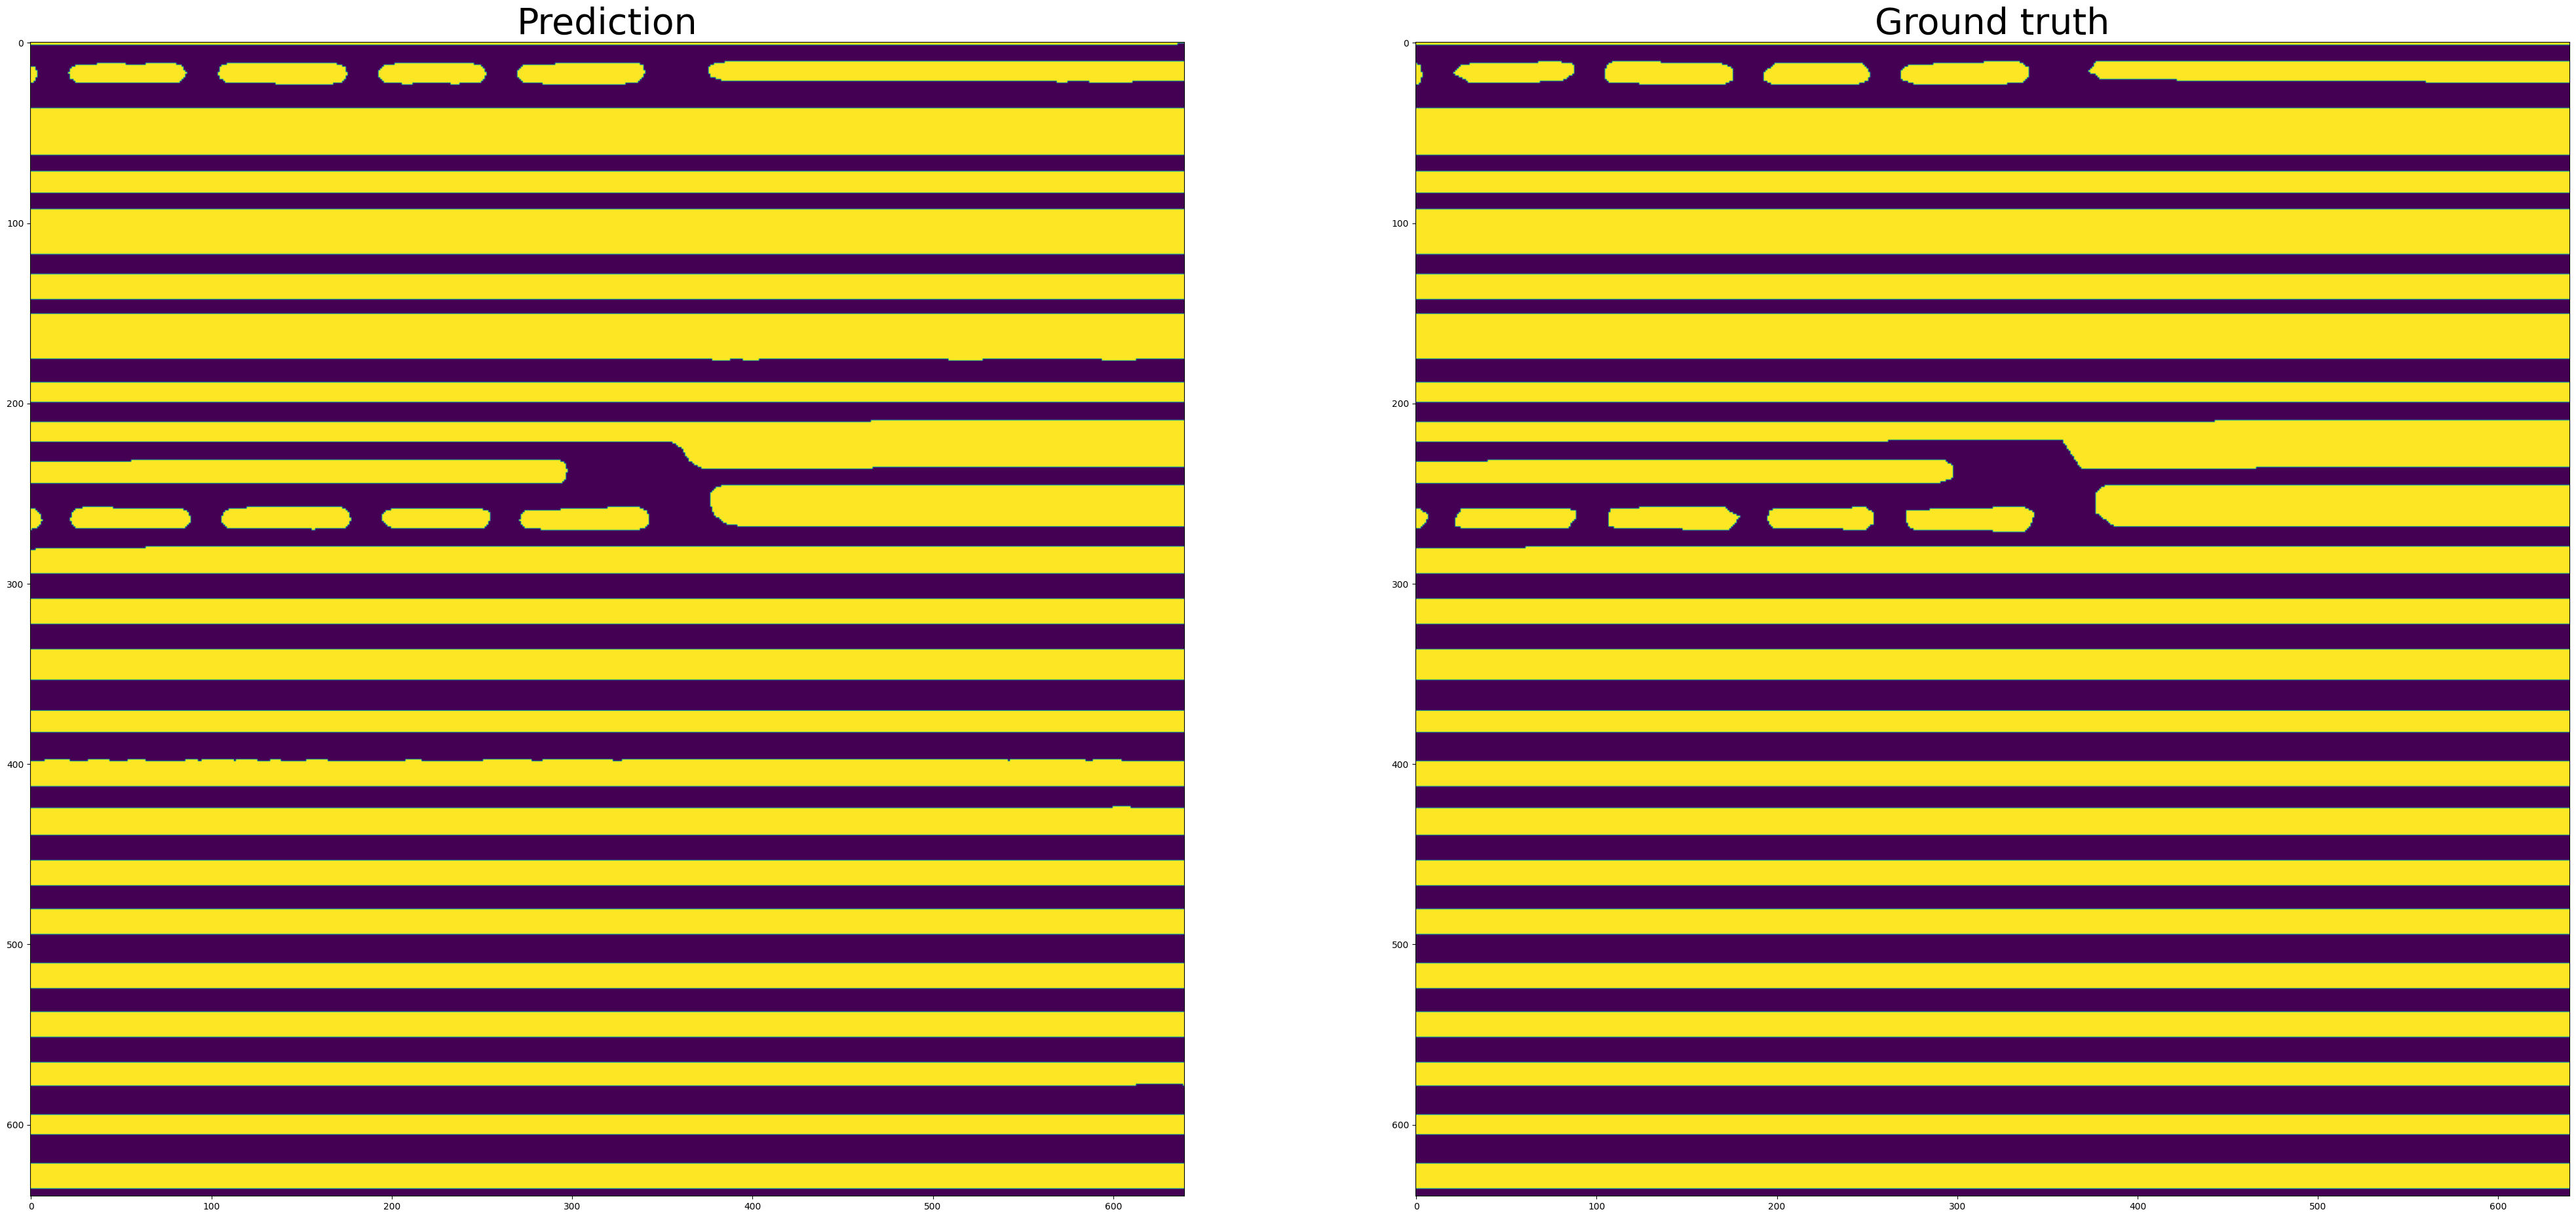

In [25]:
viewPrediction(pred_semantic_map,label)

### Define a function to display a prediction overlay in which blue represents correct prediction while red represent in correct prediction

In [26]:
def wrongPredictionOverlay(image,label):
    matches = image == label
    # Create an array highlighting wrong predictions: 0 for correct predictions, 2 for mismatches
    wrong_predictions = np.where(matches, 0, image)
    wrong_predictions[wrong_predictions==1]=2
    array_3d_colored = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    color_map = {
        0:(0,0,0),
        1:(0,128,128),
        2:(255,0,0)
        }
    for id, color in color_map.items():
        array_3d_colored[image == id] = color
        array_3d_colored[wrong_predictions == id] = color
    
    # Display the original and transformed images
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Prediction overlay", {'fontsize': 40})
    axs[0].imshow(array_3d_colored)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

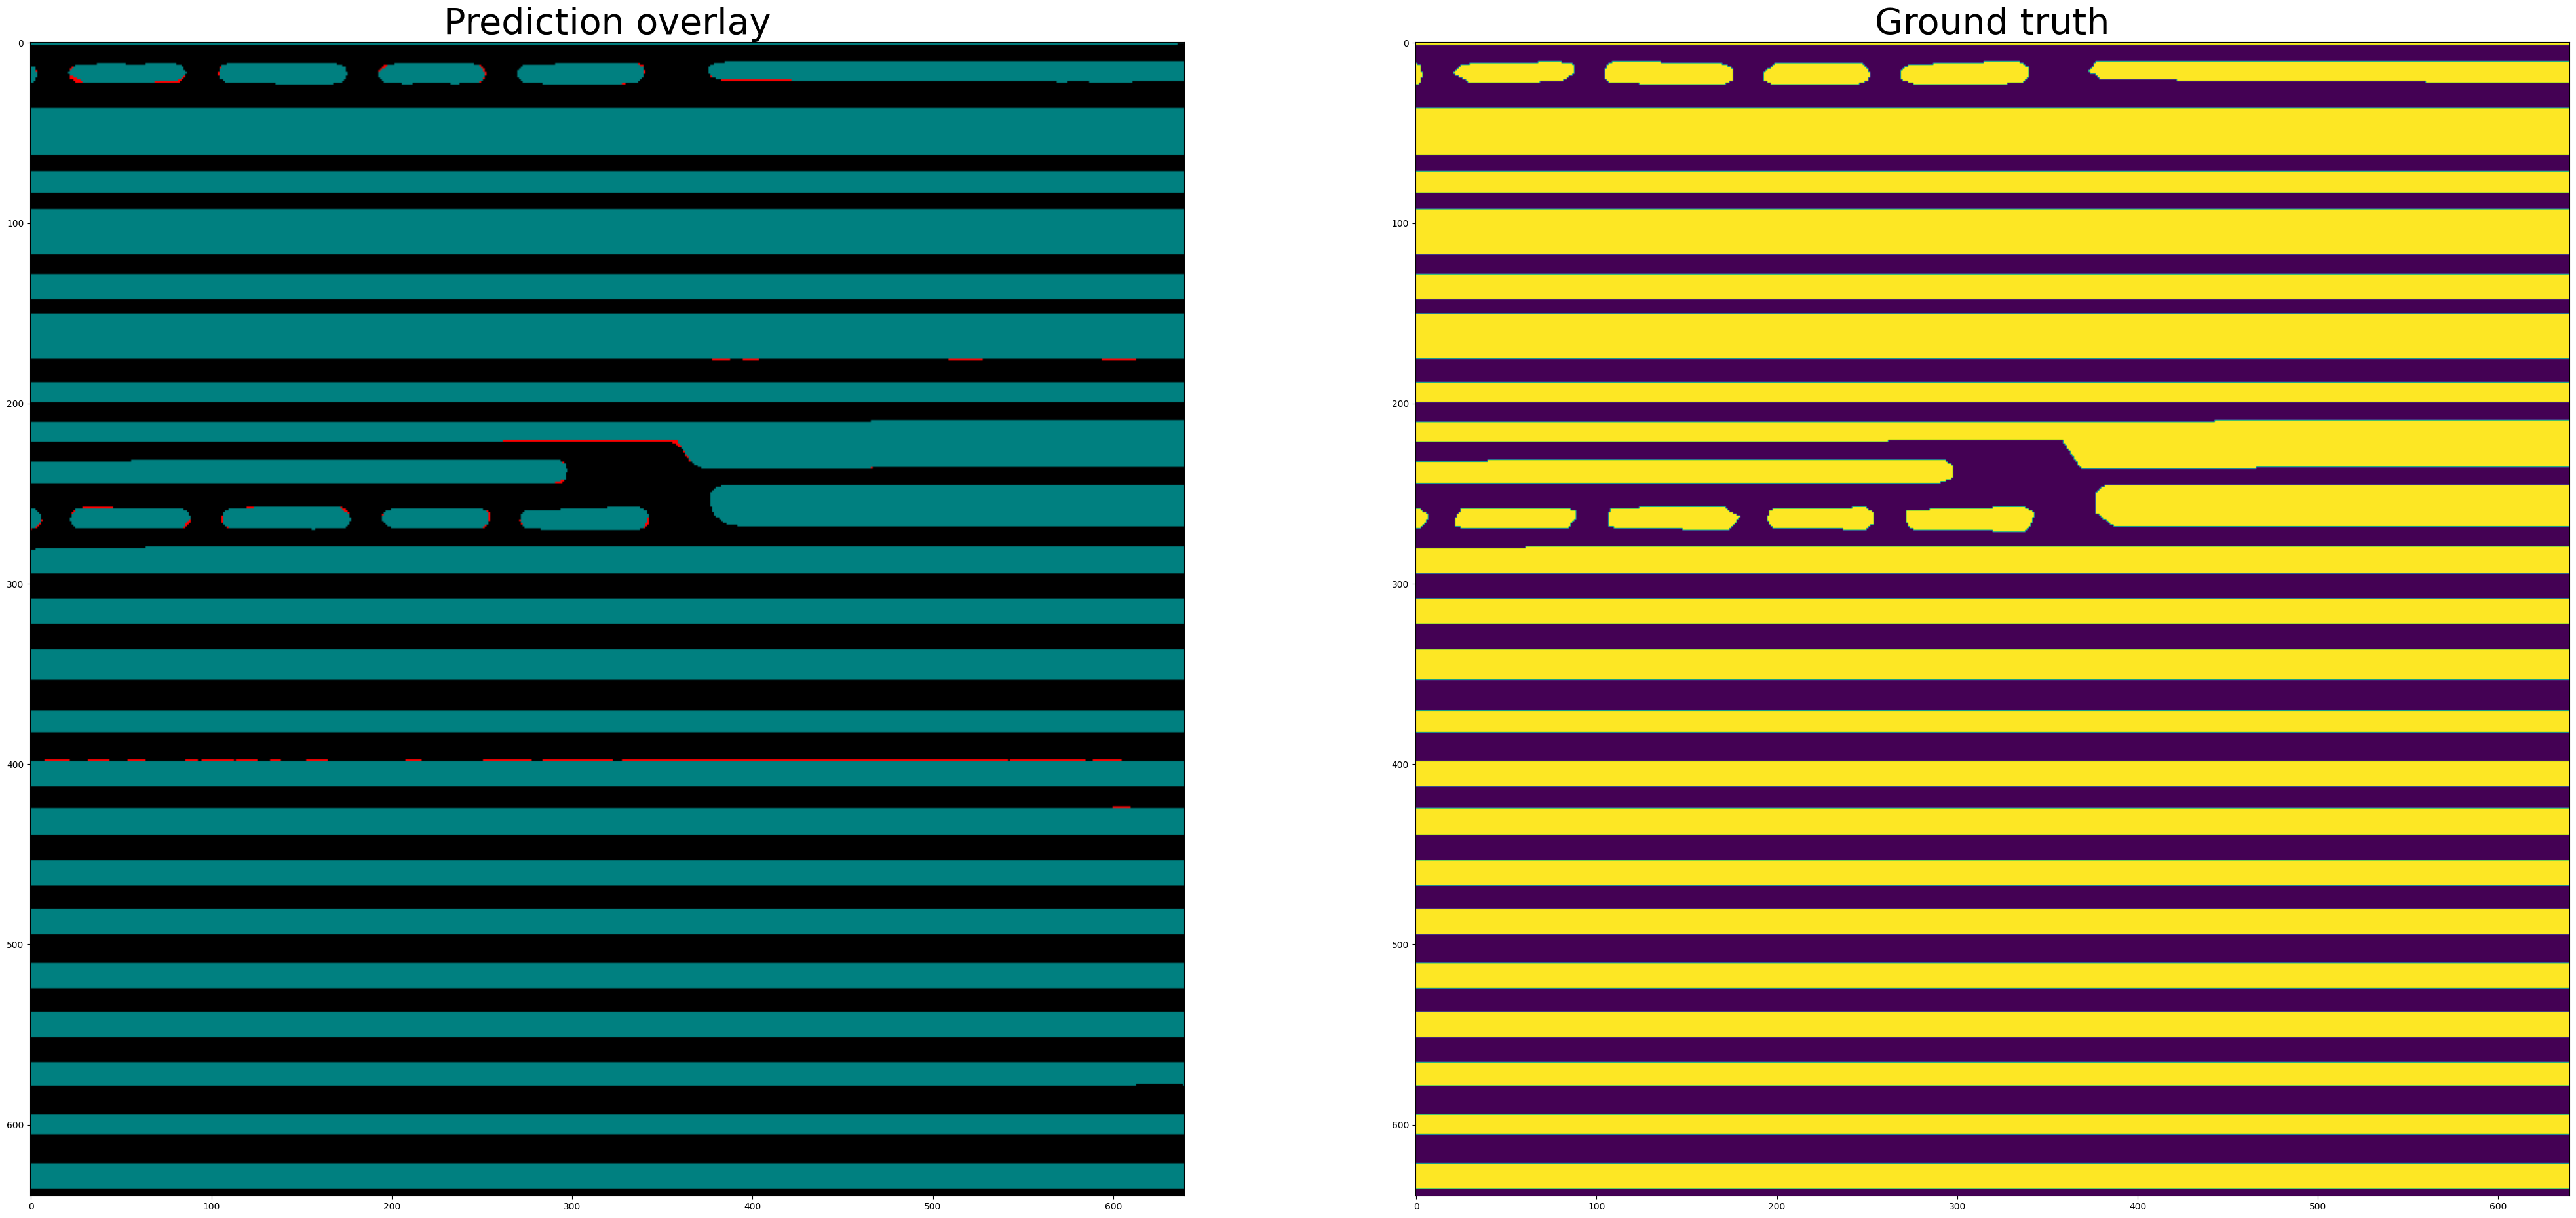

In [27]:
wrongPredictionOverlay(pred_semantic_map,label)

### Function to compute Miou for single image

In [28]:
def miou(pred,label):
    metric = evaluate.load("mean_iou")
    # Now your data should match the expected format:
    metrics = metric._compute(
        predictions=pred,
        references=label,
        num_labels=len(newid2label),
        ignore_index=254
    )
      # add per category metrics as individual key-value pairs
    # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    # Re-define metrics dict to include per-category metrics directly
    metrics = {
        "mean_iou": metrics["mean_iou"], 
        "mean_accuracy": metrics["mean_accuracy"],
        **{f"accuracy_{newid2label[i]}": v for i, v in enumerate(per_category_accuracy)},
        **{f"iou_{newid2label[i]}": v for i, v in enumerate(per_category_iou)}
    }
    
    return metrics

In [29]:
miou(pred_semantic_map,label)

{'mean_iou': 0.9937959133495631,
 'mean_accuracy': 0.9968362645840767,
 'accuracy_Background': 0.9958789981339852,
 'accuracy_Metal Lines': 0.9977935310341683,
 'iou_Background': 0.9933518237918723,
 'iou_Metal Lines': 0.994240002907254}

### Function to sort all the predictions of the dataset into list

In [30]:
def dataset_prediction(test_dataloader):
    result_list=[]
    original_seg_maps_list=[]
    for batch in test_dataloader:
        original_images = batch["original_images"]
        target_sizes = [(image.shape[1], image.shape[2]) for image in original_images]
        outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
          )
        result = processor.post_process_semantic_segmentation(outputs,target_sizes=target_sizes)[0]
        result=result.cpu().numpy()
        result_list.append(result)
        original_seg_maps_list.append(batch['original_segmentation_maps'][0])
    return result_list, original_seg_maps_list

In [31]:
result_list, original_seg_maps_list=dataset_prediction(test_dataloader)

### Function to compute mean-Iou for test dataset

In [32]:
def dateset_miou(result_list, original_seg_maps_list):
    metric = evaluate.load("mean_iou")
    # Now your data should match the expected format:
    metrics = metric._compute(
        predictions=result_list,
        references=original_seg_maps_list,
        num_labels=len(newid2label),
        ignore_index=254
    )
      # add per category metrics as individual key-value pairs
    # Extract per category metrics and convert to list if necessary (pop before defining the metrics dictionary)
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()
    
    # Re-define metrics dict to include per-category metrics directly
    metrics = {
        "mean_iou": metrics["mean_iou"], 
        "mean_accuracy": metrics["mean_accuracy"],
        **{f"accuracy_{newid2label[i]}": v for i, v in enumerate(per_category_accuracy)},
        **{f"iou_{newid2label[i]}": v for i, v in enumerate(per_category_iou)}
    }
    return metrics

In [33]:
dateset_miou(result_list, original_seg_maps_list)

{'mean_iou': 0.9598818524597084,
 'mean_accuracy': 0.9794750109933109,
 'accuracy_Background': 0.9771732844663699,
 'accuracy_Metal Lines': 0.981776737520252,
 'iou_Background': 0.9567891886349561,
 'iou_Metal Lines': 0.9629745162844607}

In [ ]:
    f, axs = plt.subplots(1, 2)
    f.set_figheight(30)
    f.set_figwidth(50)
    axs[0].set_title("Image", {'fontsize': 40})
    axs[0].imshow(image_transpose)
    axs[1].set_title("Ground truth", {'fontsize': 40})
    axs[1].imshow(label)

### Function to save all the predictions 

In [43]:
from matplotlib import pyplot as plt
def savePredictions(result_list, original_seg_maps_list, save_path):
    for i in range(len(result_list)):
        file_name = f"result_{i}"
        # Set up the plot
        f, axs = plt.subplots(1, 2)
        f.set_figheight(30)
        f.set_figwidth(50)
        
        axs[0].set_title("Prediction", {'fontsize': 40})
        axs[0].imshow(result_list[i])
        axs[1].set_title("Ground truth", {'fontsize': 40})
        axs[1].imshow(original_seg_maps_list[i])
    
        # Construct the full path where the image will be saved
        file_path = os.path.join(save_path, f"{file_name}.png")
    
        # Save the figure
        plt.savefig(file_path, bbox_inches='tight')
        plt.close(f)  # Close the figure to free memory
    print("Predictions saved")

In [44]:
save_path='data_augmentation_dataset/outputs-mask2former/'
savePredictions(result_list, original_seg_maps_list,save_path)

Predictions saved
